##### Imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import gc

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

In [ ]:
DATA_STORE = Path('/home/sayem/Desktop/Project/data/assets.h5')

In [ ]:
with pd.HDFStore(DATA_STORE) as store:
    print(store.keys())

In [ ]:
with pd.HDFStore(DATA_STORE) as store:
    nyse_stocks = store['/stooq/us/nyse/stocks/prices']
    nasdaq_stocks = store['/stooq/us/nasdaq/stocks/prices']
    metadata = store['us_equities/stocks'].loc[:, ['market cap', 'sector']]

In [ ]:
# Concatenate the two DataFrames
data = pd.concat([nyse_stocks, nasdaq_stocks])

# Drop NaN values and duplicates
data = data.dropna().drop_duplicates()

# Display the cleaned DataFrame
print(data.info())

In [ ]:
metadata.sector = pd.factorize(metadata.sector)[0]
metadata.info()

In [ ]:
metadata

In [ ]:
data = data.join(metadata).dropna(subset=['sector'])

In [ ]:
print(f"# Tickers: {len(data.index.unique('ticker')):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

In [ ]:
# Identifying duplicate entries based on index
duplicates = data[data.duplicated(keep=False)]
print(duplicates)

##### Select 500 most-traded stocks

In [ ]:
dv = data.close.mul(data.volume)
dv = dv[~dv.index.duplicated(keep='first')]

In [ ]:
top500 = (dv.groupby(level='date')
          .rank(ascending=False)
          .unstack('ticker')
          .dropna(thresh=8*252, axis=1)
          .mean()
          .nsmallest(500))

##### Visualize the 200 most liquid stocks

In [ ]:
dv = data.close.mul(data.volume).div(1e6)  # scaling values to millions
dv = dv[~dv.index.duplicated(keep='first')]

# Group by date and ticker, then by ticker alone
avg_dv_per_ticker = dv.groupby(level=['date', 'ticker']).mean().groupby(level='ticker').mean()

# Get top 200 tickers based on the average dollar volume
top200_tickers = avg_dv_per_ticker.nlargest(200)

cutoffs = [0, 50, 100, 150, 200]
fig, axes = plt.subplots(ncols=4, figsize=(20, 10), sharex=True)
axes = axes.flatten()

for i, cutoff in enumerate(cutoffs[1:], 1):
    top200_tickers.iloc[cutoffs[i-1]:cutoffs[i]].sort_values().plot.barh(logx=True, ax=axes[i-1])

fig.tight_layout()

In [ ]:
to_drop = data.index.unique('ticker').difference(top500.index)

In [ ]:
len(to_drop)

In [ ]:
data = data.drop(to_drop, level='ticker')

In [ ]:
data.info(null_counts=True)

In [ ]:
print(f"# Tickers: {len(data.index.unique('ticker')):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

##### Remove outlier observations based on daily returns

In [ ]:
before = len(data)
data['ret'] = data.groupby('ticker').close.pct_change()
data = data[data.ret.between(-1, 1)].drop('ret', axis=1)
print(f'Dropped {before-len(data):,.0f}')

In [ ]:
data.info()

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

def test_stationarity(df, ticker):
    # Extract relevant data for the ticker
    ticker_data = df.loc[ticker]
    
    # Ensure data covers at least 2 years, otherwise return a message
    if len(ticker_data) < 2 * 252:  # Assuming 252 trading days in a year
        return f"Insufficient data for {ticker}. Need at least 2 years of data."

    # Calculate log and percentage returns
    ticker_data['log_ret'] = np.log(ticker_data['close'] / ticker_data['close'].shift(1))
    ticker_data['pct_ret'] = ticker_data['close'].pct_change()

    # Drop NaN values (the first row after computing returns)
    ticker_data = ticker_data.dropna()

    # Test stationarity for each series using ADF
    adf_price = adfuller(ticker_data['close'])
    adf_log_ret = adfuller(ticker_data['log_ret'])
    adf_pct_ret = adfuller(ticker_data['pct_ret'])
    
    # Store results in a dictionary for comparison
    results = {
        'price': adf_price[0],
        'log_ret': adf_log_ret[0],
        'pct_ret': adf_pct_ret[0]
    }
    # Find which series is the most stationary based on the ADF statistic (the lower, the better)
    most_stationary = min(results, key=results.get)
    
    return most_stationary, results

# Example usage:
ticker = 'AAPL'  # Replace with desired ticker
most_stationary, results = test_stationarity(data, ticker)
print(f"For {ticker}, the most stationary series is: {most_stationary}.")
print("ADF Results:", results)

In [ ]:
tickers = data.index.unique('ticker')
print(f"# Tickers: {len(tickers):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

##### Compute returns
- Frac diff

In [ ]:
import numpy as np
import pandas as pd
from tsfracdiff import FractionalDifferentiator

def process_tickers(df, num_tickers=None):
    processed_dfs = []

    # If num_tickers is not provided, process all tickers
    if num_tickers is None:
        ticker_groups = list(df.groupby(level=0))
    else:
        ticker_groups = list(df.groupby(level=0))[:num_tickers]

    for ticker, group in ticker_groups:
        group_copy = group.copy()

        # Calculate X_frac 
        frac_diff = FractionalDifferentiator()
        X_frac = frac_diff.FitTransform(group_copy[['close']])
    
        # The number of NaN values needed to align X_frac with close
        nans_needed = len(group_copy) - len(X_frac)

        # Create a NaN series of required length
        nan_series = pd.Series([np.nan] * nans_needed)

        # Append the NaN series to the start of X_frac
        X_frac_aligned = nan_series.append(X_frac['close']).reset_index(drop=True)

        # Add the aligned X_frac to the group
        column_name = f"ret_frac_order"
        group_copy[column_name] = X_frac_aligned.values

        processed_dfs.append(group_copy)

    # Concatenate all processed dataframes
    result_df = pd.concat(processed_dfs)

    return result_df

# Process all tickers
data = process_tickers(data.copy())

In [ ]:
data.info()

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import numpy as np

# Removing NaN values from 'ret_frac_order' for the analysis
data_filtered = data['ret_frac_order'].dropna()

In [80]:
data_filtered.info()

<class 'pandas.core.series.Series'>
MultiIndex: 1336327 entries, ('AA', Timestamp('2013-01-04 00:00:00')) to ('ZTS', Timestamp('2023-08-11 00:00:00'))
Series name: ret_01d
Non-Null Count    Dtype  
--------------    -----  
1336327 non-null  float64
dtypes: float64(1)
memory usage: 15.4+ MB


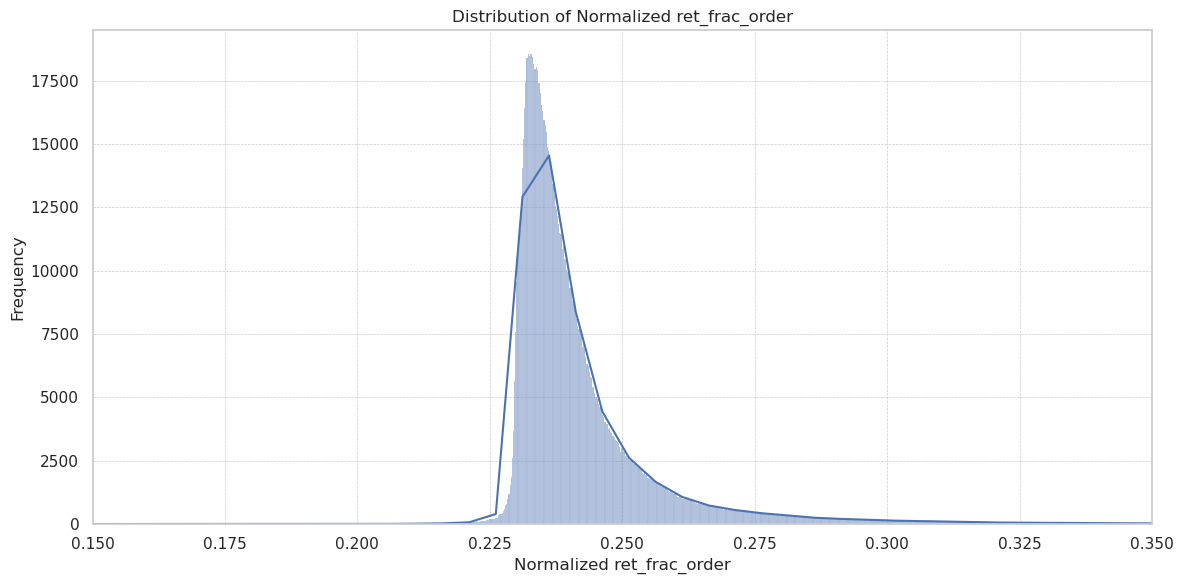

In [90]:
# Removing NaN values from 'ret_frac_order' for the analysis
data_filtered = data['ret_frac_order'].dropna()

# Normalize the data
data_min = data_filtered.min()
data_max = data_filtered.max()
normalized_data = (data_filtered - data_min) \
    / (data_max - data_min)

# Plot the distribution of the normalized data
plt.figure(figsize=(12, 6))

# Adjust the x-scale
plt.xlim(0.15, 0.35)

sns.histplot(normalized_data, bins="auto", kde=True)
plt.title('Distribution of Normalized ret_frac_order')
plt.xlabel('Normalized ret_frac_order')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

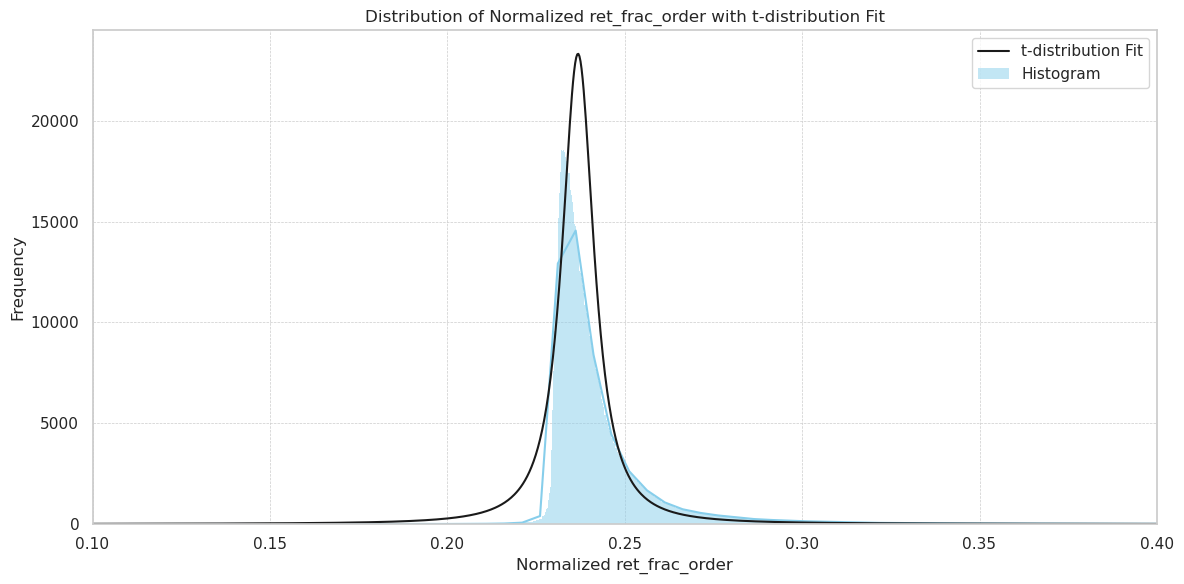

In [86]:
from scipy.stats import t
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Removing NaN values from 'ret_frac_order' for the analysis
data_filtered = data['ret_frac_order'].dropna()

# Normalize the data
data_min = data_filtered.min()
data_max = data_filtered.max()
normalized_data = (data_filtered - data_min) / (data_max - data_min)

# Fit a t-distribution to the data
params = t.fit(normalized_data)

# Plot the histogram of the data
plt.figure(figsize=(12, 6))
sns.histplot(normalized_data, bins="auto", kde=True, color="skyblue", label="Histogram")
plt.title('Distribution of Normalized ret_frac_order with t-distribution Fit')
plt.xlabel('Normalized ret_frac_order')
plt.ylabel('Frequency')

# Adjust the x-scale
plt.xlim(0.1, 0.4)

# Overlay the fitted t-distribution
x = np.linspace(0.1, 0.4, 1000)
pdf_fitted = t.pdf(x, *params)
plt.plot(x, pdf_fitted * len(normalized_data) * (x[1] - x[0]), '-k', label="t-distribution Fit")

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

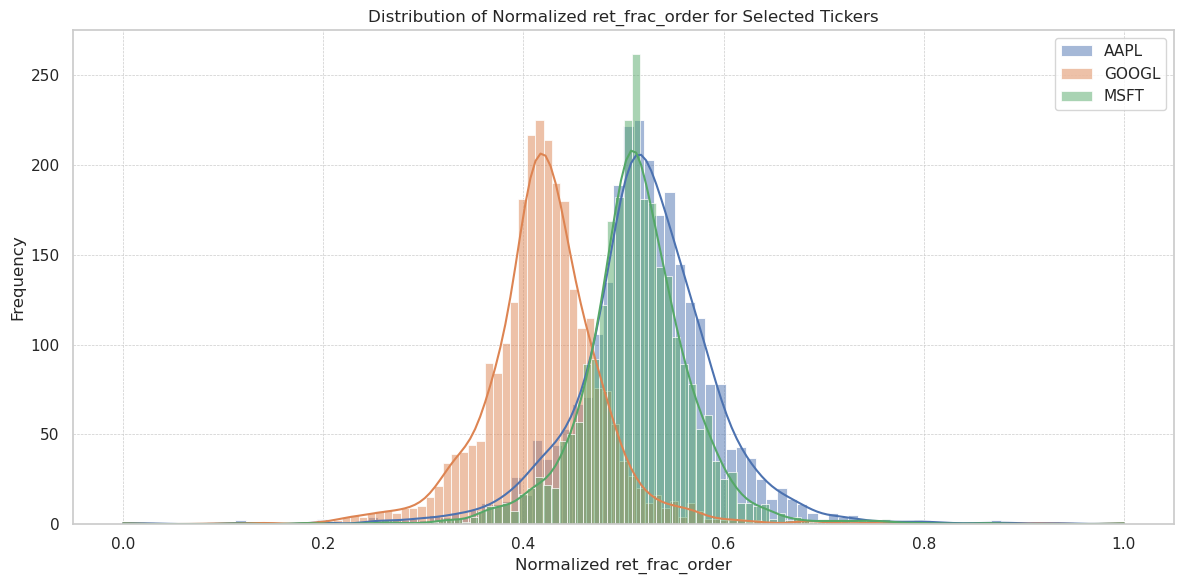

In [82]:
# Define the tickers for which you want to plot the distribution
tickers_to_plot = ['AAPL', 'GOOGL', 'MSFT']  # example tickers

plt.figure(figsize=(12, 6))

# Loop through each ticker and plot the distribution
for ticker in tickers_to_plot:
    # Filter the data for the specified ticker
    ticker_data = data_filtered.loc[ticker]
    
    # Normalize the ticker_data
    data_min = ticker_data.min()
    data_max = ticker_data.max()
    normalized_ticker_data = (ticker_data - data_min) / (data_max - data_min)

    # Plot the distribution of the normalized data for the given ticker
    sns.histplot(normalized_ticker_data, bins="auto", kde=True, label=ticker)

plt.title(f'Distribution of Normalized ret_frac_order for Selected Tickers')
plt.xlabel('Normalized ret_frac_order')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


- Historical returns

In [76]:
T = [1, 2, 3, 4, 5, 10, 21, 42, 63, 126, 252]

by_ticker = data.groupby(level='ticker')

for t in T:
    data[f'ret_{t:02}d'] = by_ticker.close.pct_change(t)

In [77]:
t = 1
data_filtered = data[f'ret_{t:02}d'].dropna()

##### Forward returns

In [ ]:
data['ret_fwd_01d'] = by_ticker.ret_01d.shift(-1)
data = data.dropna(subset=['ret_fwd_01d'])

In [ ]:
data

##### Persist results

In [ ]:
import pandas as pd
import gc
from utils import optimize_dataframe

df_optimized = optimize_dataframe(data.copy())

In [ ]:
df_optimized

In [ ]:
df_optimized.info(null_counts=True)

In [ ]:
df_optimized.to_hdf(DATA_STORE, 'data/top500_dataset')